### Importing Libraries

In [1]:
# Importing required libraries

import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import imblearn
from collections import Counter
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn import tree
import numpy as np
import collections
import joblib

import matplotlib.pyplot as  plt
import seaborn as sns

### Data Preprocessing

In [4]:
data_df = pd.read_csv("data/data_interview_test.csv", header=0, low_memory=False, delimiter = ':')
data_df.head()

,receipt_id,company_id,matched_transaction_id,feature_transaction_id,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch
0,10000,10000,10468,10000,0.0,0.0,0.0,1,0,0.0,0,1,0.0,0
1,10000,10000,10468,10001,0.0,0.0,0.0,1,0,0.0,0,1,0.0,0
2,10000,10000,10468,10003,0.0,0.0,0.0,1,0,0.0,0,1,0.0,0
3,10000,10000,10468,10004,0.0,0.0,0.0,1,0,0.0,0,1,0.0,0
4,10000,10000,10468,10005,0.0,0.0,0.0,1,0,0.0,0,1,0.0,0


In [5]:
# Understanding type of features in the data
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12034 entries, 0 to 12033
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   receipt_id               12034 non-null  int64  
 1   company_id               12034 non-null  int64  
 2   matched_transaction_id   12034 non-null  int64  
 3   feature_transaction_id   12034 non-null  int64  
 4   DateMappingMatch         12034 non-null  float64
 5   AmountMappingMatch       12034 non-null  float64
 6   DescriptionMatch         12034 non-null  float64
 7   DifferentPredictedTime   12034 non-null  int64  
 8   TimeMappingMatch         12034 non-null  int64  
 9   PredictedNameMatch       12034 non-null  float64
 10  ShortNameMatch           12034 non-null  int64  
 11  DifferentPredictedDate   12034 non-null  int64  
 12  PredictedAmountMatch     12034 non-null  float64
 13  PredictedTimeCloseMatch  12034 non-null  int64  
dtypes: float64(5), int64(9

In [6]:
# Creating the Labelled column from the data

data_df['Transaction_Status']= data_df['matched_transaction_id'] == data_df['feature_transaction_id']

data_df['Transaction_Status'] = data_df['Transaction_Status'].astype("int") # convert the bool into int 

data_df['Transaction_Status'].value_counts()

0    11177
1      857
Name: Transaction_Status, dtype: int64

In [7]:
# drop the irrelevant features
data_df = data_df.drop(columns=['receipt_id', 'company_id', 'matched_transaction_id', 'feature_transaction_id'])

### Exploratory Data Analysis (EDA)

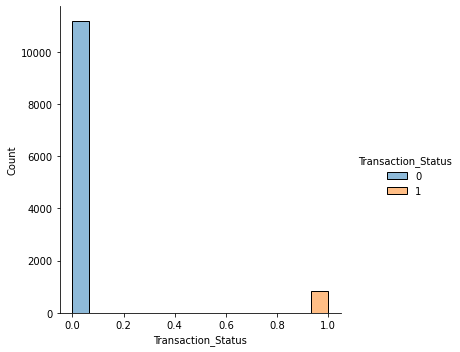

In [8]:
# visualize the target feature to understand the class imbalanace.
sns.displot(
    data=data_df,
    x='Transaction_Status',
    hue='Transaction_Status'
)

**Target Label Analysis:** From the above plot we understand that the data is highly imabaleced, hence we have to try balancing out dataset using SMOTE/Sampling Techinques and avoid using accuracy as model evaluation metrics and consider using Recall because we are more concerned in reducing False Negatives.



In [9]:
# Stats of the dataset features.

data_df.describe()

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,DifferentPredictedTime,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,DifferentPredictedDate,PredictedAmountMatch,PredictedTimeCloseMatch,Transaction_Status
count,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000,12034.000000
mean,0.217901,0.031660,0.021522,0.986455,0.013877,0.024215,0.037893,0.753532,0.001005,0.076533,0.071215
std,0.384535,0.122611,0.116995,0.115597,0.116987,0.128646,0.190945,0.430972,0.020134,0.265860,0.257194
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,0.900000,0.800000,1.000000,1.000000,0.800000,1.000000,1.000000,0.600000,1.000000,1.000000


#### Correlation Matrix

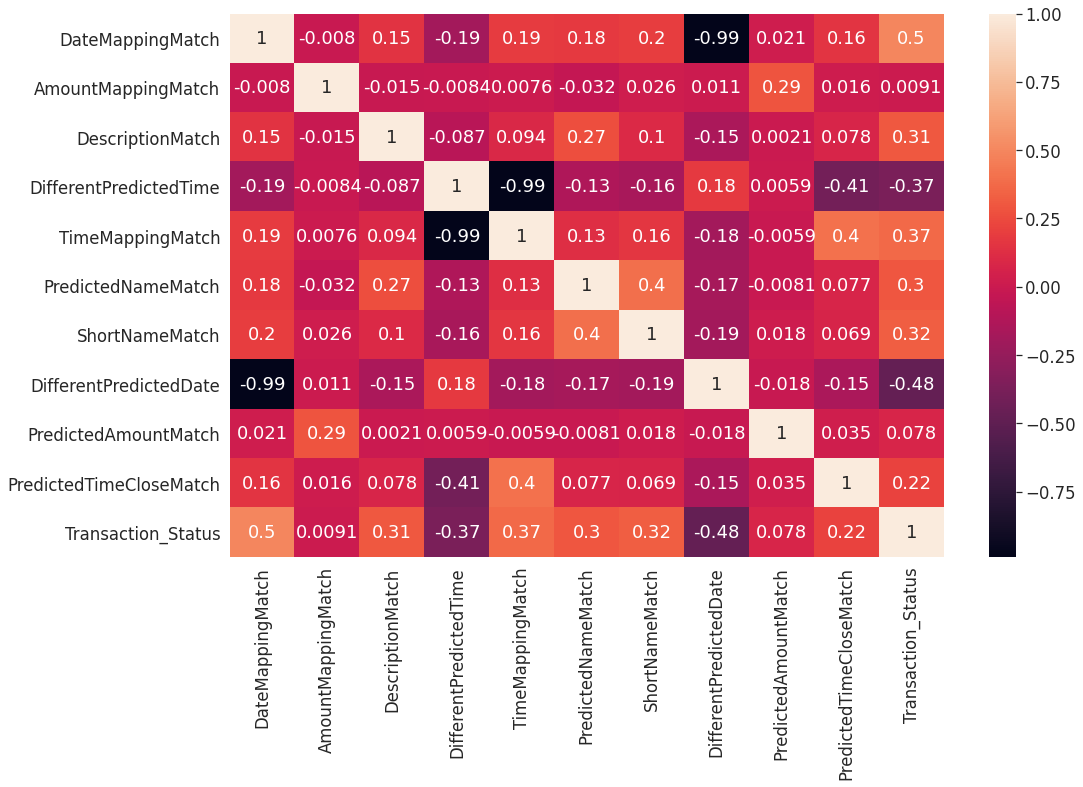

In [10]:
sns.set(font_scale=1.5)
plt.figure(figsize=(16,10))
sns.heatmap(data_df.corr(),annot=True)
plt.xticks(rotation=90)
plt.show()

From Above Correlation matrix it is clear that <font color='green'>**DateMappingMatch, TimeMappingMatch, ShortNameMatch, DescriptionMatch, PredictedNameMatch, PredictedTimeCloseMatch**</font> are the most imporant features and  <font color='red'>**DifferentPredictedDate, DifferentPredictedTime**</font> are the less important features and can be removed from the dataset prior training.

In [11]:
# drop the less important features features
data_df = data_df.drop(columns=['DifferentPredictedDate', 'DifferentPredictedTime'])

In [12]:
data_df.head()

,DateMappingMatch,AmountMappingMatch,DescriptionMatch,TimeMappingMatch,PredictedNameMatch,ShortNameMatch,PredictedAmountMatch,PredictedTimeCloseMatch,Transaction_Status
0,0.0,0.0,0.0,0,0.0,0,0.0,0,0
1,0.0,0.0,0.0,0,0.0,0,0.0,0,0
2,0.0,0.0,0.0,0,0.0,0,0.0,0,0
3,0.0,0.0,0.0,0,0.0,0,0.0,0,0
4,0.0,0.0,0.0,0,0.0,0,0.0,0,0


### Balancing the DataSet and Train-Test-Split

In [13]:
X = data_df.drop(['Transaction_Status'],axis=1)
y = data_df['Transaction_Status']

In [14]:
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (12034, 8)
y.shape (12034,)


Class=0, n=11177 (92.879%)
Class=1, n=857 (7.121%)


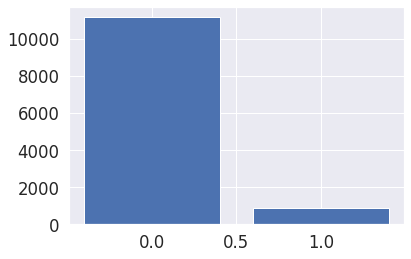

In [15]:
# summarize distribution before SMOTE
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [16]:
# transform the dataset
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)

In [17]:
print("X.shape", X.shape)
print("y.shape", y.shape)

X.shape (22354, 8)
y.shape (22354,)


Class=0, n=11177 (50.000%)
Class=1, n=11177 (50.000%)


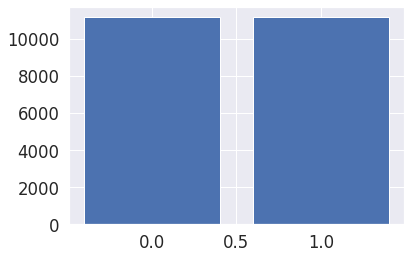

In [18]:
# summarize distribution after SMOTE
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [19]:
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=2,stratify=y)

In [20]:
print(f'X_train.shape = {X_train.shape} and X_test.shape = {X_test.shape}')

X_train.shape = (15647, 8) and X_test.shape = (6707, 8)


### Modelling and Evaluation

#### Hyper-parameter tuning function

In [21]:
def params_tuning(model,X_train,y_train,X_test,y_test,metrics,param_grid,clf=False,conf=False):
    """Tune parameters of the model using a grid search"""
    gs=GridSearchCV(model,param_grid=param_grid,scoring=metrics,cv=10)
    gs.fit(X_train,y_train)
    predicted = gs.predict(X_test)
    proba = gs.predict_proba(X_test)[:,1]
    if clf == True:
        print (classification_report(y_test,predicted))
    if conf == True:
#         print (confusion_matrix(y_test,predicted))
        sns.heatmap(confusion_matrix(y_test,predicted), annot=True,  fmt='');
    print (gs.best_params_)
    print (roc_auc_score(y_test,proba),'Optimised Score')

#### K Nearest Neighbors

0.9571867662366278 Initial Score
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3354
           1       0.86      0.99      0.92      3353

    accuracy                           0.92      6707
   macro avg       0.93      0.92      0.92      6707
weighted avg       0.93      0.92      0.92      6707

{'n_neighbors': 15, 'weights': 'distance'}
0.9654723624355123 Optimised Score


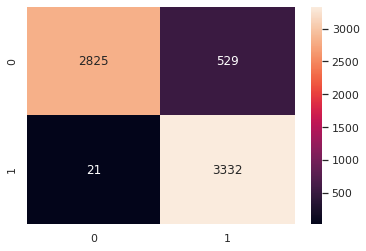

In [93]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
knnp = knn.predict_proba(X_test)
print (roc_auc_score(y_test,knnp[:,1]),"Initial Score")
weight_options = ['uniform','distance']
params_grid_knn = dict(n_neighbors = range(1,18) ,weights=weight_options)
params_tuning(knn,X_train,y_train,X_test,y_test,'roc_auc',params_grid_knn,clf=True,conf=True)

#### Support Vector Machine

0.9528835327738081 Initial Score
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      3354
           1       0.85      1.00      0.92      3353

    accuracy                           0.91      6707
   macro avg       0.93      0.91      0.91      6707
weighted avg       0.93      0.91      0.91      6707

{'C': 0.55}
0.9436267435369246 Optimised Score


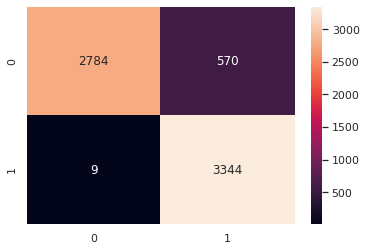

In [99]:
svc = svm.SVC(probability=True,random_state=12)
svc.fit(X_train,y_train)
scaledp = svc.predict_proba(X_test)
print (roc_auc_score(y_test,scaledp[:,1]),'Initial Score')
svcp = dict(C=np.linspace(0.1,1,5))
params_tuning(svc,X_train,y_train,X_test,y_test,'roc_auc',svcp,clf=True,conf=True)

#### Logistic Regression

0.9629357186161575 Inital Score
              precision    recall  f1-score   support

           0       0.99      0.83      0.91      3354
           1       0.86      0.99      0.92      3353

    accuracy                           0.91      6707
   macro avg       0.92      0.91      0.91      6707
weighted avg       0.93      0.91      0.91      6707

{'C': 0.19, 'solver': 'newton-cg'}
0.9622705909907929 Optimised Score


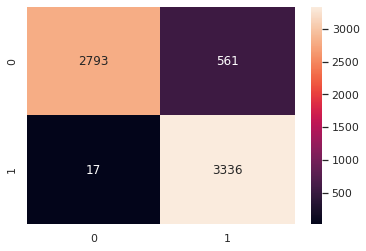

In [94]:
logreg = LogisticRegression(random_state=12)
logreg.fit(X_train,y_train)
logp = logreg.predict_proba(X_test)
print (roc_auc_score(y_test,logp[:,1]),"Inital Score")
logp = dict(C=np.linspace(0.16,0.2,5),solver=['newton-cg', 'lbfgs','sag'])
params_tuning(logreg,X_train,y_train,X_test,y_test,'roc_auc',logp,clf=True,conf=True)

#### Random Forest Classifier

0.9200946081802517 Initial Score
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      3354
           1       0.87      0.99      0.93      3353

    accuracy                           0.92      6707
   macro avg       0.93      0.92      0.92      6707
weighted avg       0.93      0.92      0.92      6707

{'n_estimators': 15}
0.9686531930305295 Optimised Score


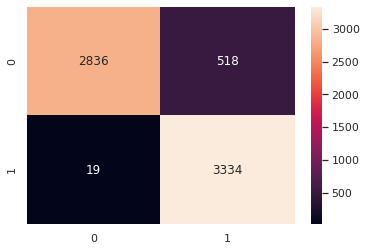

In [98]:
rf = RandomForestClassifier() #Random Forest
rf.fit(X_train,y_train)
rfpred=rf.predict(X_test)
rfp = dict(n_estimators=np.arange(5,25,10))
print (roc_auc_score(y_test,rfpred),'Initial Score')
params_tuning(rf,X_train,y_train,X_test,y_test,'roc_auc',rfp,clf=True,conf=True)

#### Adaptive Boosting

0.9647567277926068 Initial Score
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3354
           1       0.86      0.99      0.92      3353

    accuracy                           0.91      6707
   macro avg       0.93      0.91      0.91      6707
weighted avg       0.93      0.91      0.91      6707

{'learning_rate': 1, 'n_estimators': 75}
0.9644282987973816 Optimised Score


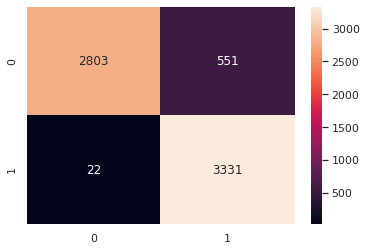

In [96]:
ada = AdaBoostClassifier(algorithm='SAMME')
ada.fit(X_train,y_train)
adaproba= ada.predict_proba(X_test)
print (roc_auc_score(y_test,adaproba[:,1]),'Initial Score')
adap = dict(n_estimators=[25,50,75],learning_rate =[0.25,0.5,0.75,1])
params_tuning(ada,X_train,y_train,X_test,y_test,'roc_auc',adap,clf=True,conf=True)

#### Gradient Boosting 

In [73]:
### tree specific parameters
gbr = GradientBoostingClassifier(n_estimators=70,min_samples_split=75,max_depth=8,min_samples_leaf=50,max_features='sqrt',subsample=0.8,random_state=12)
gbrd = dict(max_depth=range(5,16,2),min_samples_split = range(15,80,10))
params_tuning(gbr,X_train,y_train,X_test,y_test,'roc_auc',gbrd)

{'max_depth': 7, 'min_samples_split': 15}
0.9684214209509155 Optimised Score


              precision    recall  f1-score   support

           0       0.99      0.84      0.91      3354
           1       0.86      1.00      0.92      3353

    accuracy                           0.92      6707
   macro avg       0.93      0.92      0.92      6707
weighted avg       0.93      0.92      0.92      6707

{'subsample': 0.8}
0.9684433843898814 Optimised Score


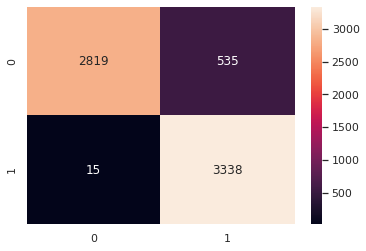

In [97]:
# subsample
gbr = GradientBoostingClassifier(min_samples_split=15,max_depth=15,n_estimators=70,min_samples_leaf=50,max_features='sqrt',random_state=12)
gbrd = dict(subsample=[0.75,0.8,0.85,0.9])
params_tuning(gbr,X_train,y_train,X_test,y_test,'roc_auc',gbrd,clf=True,conf=True)

### ANN

In [43]:
# sequential model to initialise our ann and dense module to build the layers
from keras.models import Sequential
from keras.layers import Dense

In [48]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu', input_dim = 8))

# Adding the second hidden layer
classifier.add(Dense(units = 8, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

/home/sundeepkondaveeti/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Train score: 0.2008941842550441
Train accuracy: 0.9176839
********************
Test score: 0.2050365752402226
Test accuracy: 0.91561055


/home/sundeepkondaveeti/.local/lib/python3.8/site-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Text(0.5, 4.5, 'Predicted label')

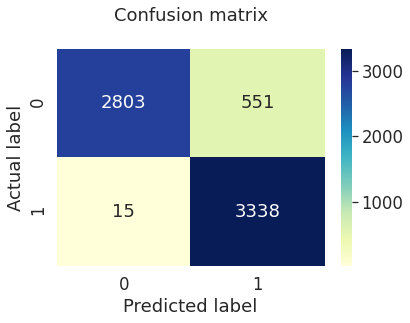

In [49]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

#### Ranking Models

In [50]:
scores_list= pd.DataFrame(collections.OrderedDict([('Model',['K Neighbors','Support Vector Machine','Logistic Regression','Random Forest','Adaptive Boosting','Gradient Boosting', 'Artificial Neural Network Classifier']),('AUC_Score',[0.9654723624355123,0.9436267435369246,0.9622705909907929,0.9686531930305295,0.9644282987973816, 0.9684433843898814, 0.9176839])])) 
print (scores_list.sort_values('AUC_Score',ascending=False))

                                  Model  AUC_Score
3                         Random Forest   0.968653
5                     Gradient Boosting   0.968443
0                           K Neighbors   0.965472
4                     Adaptive Boosting   0.964428
2                   Logistic Regression   0.962271
1                Support Vector Machine   0.943627
6  Artificial Neural Network Classifier   0.917684


#### Feature Importance Plotting

In [82]:
def importance_plotting(data,x,y,palette,title):
    sns.set(style="whitegrid")
    ft = sns.PairGrid(data,y_vars=y,x_vars=x,size=5,aspect=1)
    ft.map(sns.stripplot,orient='h',palette=palette, edgecolor="black",size=15)
    for ax, title in zip(ft.axes.flat, titles):
    # Set a different title for each axes
        ax.set(title=title)
    # Make the grid horizontal instead of vertical
        ax.xaxis.grid(False)
        ax.yaxis.grid(True)
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


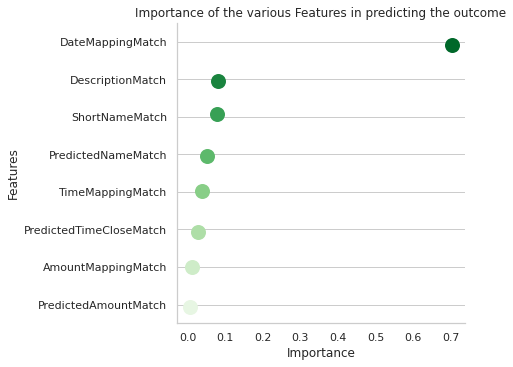

In [87]:
ho = {'Features':data_df.drop('Transaction_Status',axis=1).columns.tolist(),'Importance':rf.feature_importances_}
ImportanceRF = pd.DataFrame(ho,index=None).sort_values('Importance',ascending=False)
titles = ["Importance of the various Features in predicting the outcome"]

importance_plotting(ImportanceRF,'Importance','Features','Greens_r',titles)

#### Save the best model for futuristic predictions.

In [131]:
rf_final = RandomForestClassifier(n_estimators= 30) #Random Forest
rf_final.fit(X_train,y_train)

# save the model to disk
filename = 'tide_finalized_model_1.sav'
joblib.dump(rf_final, filename)

['tide_finalized_model_1.sav']

### Conclusion

After analysing the features provided, dropped some of the features which are not important. Drawn relevant insights from our **Exploratory Data Analysis (EDA)** and modelled the data over various classification algorithms with combination of hypermareters and clearly see that **Random Forest Classifer** provides best results.